In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os 

Keras is a deep learning API written in Python, running on top of ther machine learning platform TensorFlow. Keras was developed with a focus on enabling fast experimentation.

So Keras is a high-level neural network library that runs on top of TensorFlow. Keras is more user friendly because it's built in Python.

In [2]:
#from sklearn.metrics import accuracy_score, precision_score, recall_score
#from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
#from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import History 
#from tensorflow.keras.layers import Dense, BatchNormalization

Callbacks: A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

Callbacks can be used to:
   * Monitor metrics by writing TensorBoard logs
   * Periodically save model to disk drive
   * Do early stopping
   * Get internal states and stats during training
   * and more!

In [3]:
history = History()

In [4]:
training_index = "31_cut"

In [11]:
star_spec = np.load("/home/jovyan/work/stampede2/Nick_Capstone_Project/Valentina_samples/star_spec_reduced.npy") 
agn_spec = np.load("/home/jovyan/work/stampede2/Nick_Capstone_Project/Valentina_samples/all_agn_no_duplicates.npy")
lowz_spec = np.load("/home/jovyan/work/stampede2/Nick_Capstone_Project/Valentina_samples/lowz_no_duplicates.npy")
gal_spec = np.load("/home/jovyan/work/stampede2/Nick_Capstone_Project/Valentina_samples/gal_sample.npy")

In [12]:
def isNaN(num):
    return num != num

In [13]:
# If there are any files in the imports without any numbers I assume we remove them
def remove_nan(file):
    for i in range(0,len(file)):
        for j in range(0,len(file[i])):
            if isNaN(file[i][j]):
                file[i][j]=0.00001

remove_nan(star_spec)
remove_nan(agn_spec)
remove_nan(lowz_spec)
remove_nan(gal_spec)

In [14]:
np.random.seed(2)
np.random.shuffle(star_spec)

In [15]:
all_images =  np.concatenate((star_spec[::90],agn_spec,lowz_spec,gal_spec))
train_images = np.concatenate((star_spec[::90][:433],agn_spec[:444],lowz_spec[:837],gal_spec[:254]))
#train_images = agn_spec[:433]
#np.random.shuffle(train_images)

In [16]:
val_images = np.concatenate((star_spec[::90][433:],agn_spec[444:],lowz_spec[837:],gal_spec[254:]))
#val_images = agn_spec[433:]
#np.random.shuffle(val_images)

In [17]:
def Norm(data):
    new_data = []
    for spec in data:
        spec = spec/spec.max()
        new_data.append(spec)
    return np.array(new_data)

In [18]:
train_images = Norm(train_images)
val_images = Norm(val_images)

In [19]:
train_cut = train_images[:,88:1002]
val_cut = val_images[:,88:1002]
train_cut = Norm(train_cut)
val_cut = Norm(val_cut)

In [20]:
latent_dim = 30
act = 'sigmoid'

In [21]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      #layers.InputLayer(input_shape=(1036)),
      layers.Dense(436, activation=act,name="e1"),
      #layers.Dropout(0.3),
      #layers.Dense(136, activation=act, name ='e2'),
      #BatchNormalization(),
      layers.Dropout(0.3),
      layers.Dense(latent_dim, activation=None, name = "e3"),
    ])
    self.decoder = tf.keras.Sequential([
      #layers.InputLayer(input_shape=(latent_dim,)),
      #layers.Dense(136, activation=act,name = "d1"),
      layers.Dense(436, activation=act,name = "d2"),
      #BatchNormalization(),
      layers.Dense(914, activation=None,name = "d3")
    ])#914 for cut. 1036 for all

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [22]:
autoencoder = Autoencoder(latent_dim)
#autoencoder.build(input_shape=np.shape(train_images))
epoch = 500

In [23]:
adg = tf.keras.optimizers.Adagrad(
    learning_rate=0.01)

In [24]:
adam = tf.keras.optimizers.Adam(
    learning_rate=0.0005)

In [25]:
def loss1(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    d = tf.reduce_mean(tf.math.square(y_pred - y_true), axis=-1)
    #tf.print(d, [d], "Inside loss function")
    #tf.print(d.shape)
    return d

autoencoder.compile(optimizer=adam, loss=loss1)#es.MeanSquaredError())

try:
    os.mkdir(f"models/training{training_index}")
    checkpoint_path = f"models/training{training_index}/cp_{training_index}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
except:
    checkpoint_path = f"models/training{training_index}/cp_{training_index}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

In [26]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
#autoencoder.summary()
#autoencoder.fit(train_images, train_images,
 #               epochs=10,
  #              shuffle=True,
   #             validation_data=(val_images,val_images))
hist = autoencoder.fit(train_cut, train_cut,
                epochs=epoch,
                shuffle=True,
                validation_data=(val_cut,val_cut),
                callbacks=[cp_callback])


Epoch 1/500
57/62 [==========================>...] - ETA: 0s - loss: 0.0799
Epoch 1: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 3s 18ms/step - loss: 0.0767 - val_loss: 0.0322
Epoch 2/500
55/62 [=========================>....] - ETA: 0s - loss: 0.0315
Epoch 2: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0311 - val_loss: 0.0250
Epoch 3/500
61/62 [============================>.] - ETA: 0s - loss: 0.0262
Epoch 3: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 8ms/step - loss: 0.0262 - val_loss: 0.0220
Epoch 4/500
56/62 [==========================>...] - ETA: 0s - loss: 0.0247
Epoch 4: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 7ms/step - loss: 0.0248 - val_loss: 0.0217
Epoch 5/500
62/62 [==============================] - ETA: 0s - loss: 0.0246
Epoch 5: saving model t

56/62 [==========================>...] - ETA: 0s - loss: 0.0196
Epoch 73: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 8ms/step - loss: 0.0197 - val_loss: 0.0177
Epoch 74/500
54/62 [=========================>....] - ETA: 0s - loss: 0.0195
Epoch 74: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0197 - val_loss: 0.0177
Epoch 75/500
57/62 [==========================>...] - ETA: 0s - loss: 0.0198
Epoch 75: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 8ms/step - loss: 0.0197 - val_loss: 0.0177
Epoch 76/500
61/62 [============================>.] - ETA: 0s - loss: 0.0196
Epoch 76: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0196 - val_loss: 0.0178
Epoch 77/500
54/62 [=========================>....] - ETA: 0s - loss: 0.0197
Epoch 77: saving model to mo

Epoch 145/500
58/62 [===========================>..] - ETA: 0s - loss: 0.0172
Epoch 145: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 8ms/step - loss: 0.0171 - val_loss: 0.0170
Epoch 146/500
60/62 [============================>.] - ETA: 0s - loss: 0.0172
Epoch 146: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0171 - val_loss: 0.0171
Epoch 147/500
55/62 [=========================>....] - ETA: 0s - loss: 0.0169
Epoch 147: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 7ms/step - loss: 0.0170 - val_loss: 0.0171
Epoch 148/500
52/62 [========================>.....] - ETA: 0s - loss: 0.0169
Epoch 148: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0170 - val_loss: 0.0171
Epoch 149/500
60/62 [============================>.] - ETA: 0s - loss: 0.0169
Epoch 

Epoch 181/500
57/62 [==========================>...] - ETA: 0s - loss: 0.0155
Epoch 181: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 8ms/step - loss: 0.0155 - val_loss: 0.0171
Epoch 182/500
54/62 [=========================>....] - ETA: 0s - loss: 0.0156
Epoch 182: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 7ms/step - loss: 0.0155 - val_loss: 0.0171
Epoch 183/500
61/62 [============================>.] - ETA: 0s - loss: 0.0155
Epoch 183: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0154 - val_loss: 0.0171
Epoch 184/500
53/62 [========================>.....] - ETA: 0s - loss: 0.0153
Epoch 184: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0154 - val_loss: 0.0172
Epoch 185/500
55/62 [=========================>....] - ETA: 0s - loss: 0.0153
Epoch 

Epoch 217/500
60/62 [============================>.] - ETA: 0s - loss: 0.0142
Epoch 217: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0142 - val_loss: 0.0173
Epoch 218/500
52/62 [========================>.....] - ETA: 0s - loss: 0.0139
Epoch 218: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0141 - val_loss: 0.0174
Epoch 219/500
60/62 [============================>.] - ETA: 0s - loss: 0.0141
Epoch 219: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 8ms/step - loss: 0.0141 - val_loss: 0.0173
Epoch 220/500
54/62 [=========================>....] - ETA: 0s - loss: 0.0140
Epoch 220: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0140 - val_loss: 0.0173
Epoch 221/500
59/62 [===========================>..] - ETA: 0s - loss: 0.0141
Epoch 

Epoch 253/500
58/62 [===========================>..] - ETA: 0s - loss: 0.0132
Epoch 253: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 9ms/step - loss: 0.0132 - val_loss: 0.0174
Epoch 254/500
57/62 [==========================>...] - ETA: 0s - loss: 0.0131
Epoch 254: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 9ms/step - loss: 0.0131 - val_loss: 0.0176
Epoch 255/500
61/62 [============================>.] - ETA: 0s - loss: 0.0132
Epoch 255: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 8ms/step - loss: 0.0132 - val_loss: 0.0175
Epoch 256/500
56/62 [==========================>...] - ETA: 0s - loss: 0.0131
Epoch 256: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 9ms/step - loss: 0.0131 - val_loss: 0.0175
Epoch 257/500
52/62 [========================>.....] - ETA: 0s - loss: 0.0132
Epoch 

Epoch 289/500
61/62 [============================>.] - ETA: 0s - loss: 0.0124
Epoch 289: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0125 - val_loss: 0.0176
Epoch 290/500
52/62 [========================>.....] - ETA: 0s - loss: 0.0125
Epoch 290: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 8ms/step - loss: 0.0124 - val_loss: 0.0176
Epoch 291/500
62/62 [==============================] - ETA: 0s - loss: 0.0125
Epoch 291: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0125 - val_loss: 0.0176
Epoch 292/500
53/62 [========================>.....] - ETA: 0s - loss: 0.0124
Epoch 292: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0124 - val_loss: 0.0176
Epoch 293/500
61/62 [============================>.] - ETA: 0s - loss: 0.0124
Epoch 

Epoch 325/500
59/62 [===========================>..] - ETA: 0s - loss: 0.0120
Epoch 325: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 9ms/step - loss: 0.0120 - val_loss: 0.0178
Epoch 326/500
56/62 [==========================>...] - ETA: 0s - loss: 0.0119
Epoch 326: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 9ms/step - loss: 0.0120 - val_loss: 0.0177
Epoch 327/500
57/62 [==========================>...] - ETA: 0s - loss: 0.0119
Epoch 327: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 8ms/step - loss: 0.0120 - val_loss: 0.0177
Epoch 328/500
59/62 [===========================>..] - ETA: 0s - loss: 0.0120
Epoch 328: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 9ms/step - loss: 0.0120 - val_loss: 0.0178
Epoch 329/500
57/62 [==========================>...] - ETA: 0s - loss: 0.0119
Epoch 

Epoch 361/500
54/62 [=========================>....] - ETA: 0s - loss: 0.0115
Epoch 361: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0116 - val_loss: 0.0178
Epoch 362/500
55/62 [=========================>....] - ETA: 0s - loss: 0.0116
Epoch 362: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0116 - val_loss: 0.0178
Epoch 363/500
56/62 [==========================>...] - ETA: 0s - loss: 0.0117
Epoch 363: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0179
Epoch 364/500
54/62 [=========================>....] - ETA: 0s - loss: 0.0115
Epoch 364: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 8ms/step - loss: 0.0116 - val_loss: 0.0178
Epoch 365/500
54/62 [=========================>....] - ETA: 0s - loss: 0.0116
Epoch 

Epoch 397/500
56/62 [==========================>...] - ETA: 0s - loss: 0.0113
Epoch 397: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 9ms/step - loss: 0.0113 - val_loss: 0.0180
Epoch 398/500
60/62 [============================>.] - ETA: 0s - loss: 0.0114
Epoch 398: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0114 - val_loss: 0.0180
Epoch 399/500
55/62 [=========================>....] - ETA: 0s - loss: 0.0114
Epoch 399: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 8ms/step - loss: 0.0113 - val_loss: 0.0180
Epoch 400/500
60/62 [============================>.] - ETA: 0s - loss: 0.0114
Epoch 400: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0114 - val_loss: 0.0179
Epoch 401/500
56/62 [==========================>...] - ETA: 0s - loss: 0.0112
Epoch 

Epoch 433/500
53/62 [========================>.....] - ETA: 0s - loss: 0.0110
Epoch 433: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0111 - val_loss: 0.0180
Epoch 434/500
61/62 [============================>.] - ETA: 0s - loss: 0.0111
Epoch 434: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 8ms/step - loss: 0.0111 - val_loss: 0.0180
Epoch 435/500
59/62 [===========================>..] - ETA: 0s - loss: 0.0111
Epoch 435: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 1s 9ms/step - loss: 0.0111 - val_loss: 0.0180
Epoch 436/500
54/62 [=========================>....] - ETA: 0s - loss: 0.0111
Epoch 436: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0111 - val_loss: 0.0180
Epoch 437/500
59/62 [===========================>..] - ETA: 0s - loss: 0.0111
Epoch 

Epoch 469/500
55/62 [=========================>....] - ETA: 0s - loss: 0.0109
Epoch 469: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0180
Epoch 470/500
57/62 [==========================>...] - ETA: 0s - loss: 0.0110
Epoch 470: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0181
Epoch 471/500
53/62 [========================>.....] - ETA: 0s - loss: 0.0110
Epoch 471: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0180
Epoch 472/500
57/62 [==========================>...] - ETA: 0s - loss: 0.0108
Epoch 472: saving model to models/training31_cut/cp_31_cut.ckpt
62/62 [==============================] - 0s 8ms/step - loss: 0.0109 - val_loss: 0.0181
Epoch 473/500
53/62 [========================>.....] - ETA: 0s - loss: 0.0109
Epoch 

(1968, 1036)


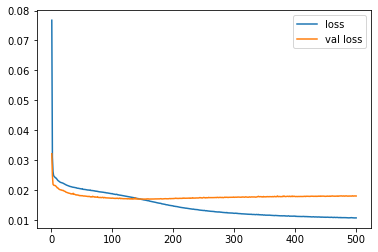

In [32]:
plt.figure()
x = np.linspace(1,epoch+1,epoch)
plt.plot(x,hist.history["loss"],label="loss")
plt.plot(x,hist.history["val_loss"],label="val loss")
plt.legend()
plt.savefig(f'Graphs/loss_{training_index}.png')
print(np.shape(train_images))

encoded_imgs = autoencoder.encoder(train_cut).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
np.save(f"encoded_{training_index}",encoded_imgs)
np.save(f"decoded_{training_index}",decoded_imgs)

encoded_val = autoencoder.encoder(val_cut).numpy()
np.save(f"encoded_val_{training_index}",encoded_val)

In [36]:
np.load("encoded_31_cut.npy")

array([[ 2.5318229e+00, -3.4176916e-01, -7.1634948e-03, ...,
        -3.7013714e+00,  1.6883920e+00,  2.1937103e+00],
       [ 1.0111198e-01,  3.3370763e-01, -9.9943411e-01, ...,
        -3.0231306e-01, -2.2436906e-01,  2.8035727e+00],
       [-2.1346807e-03,  1.0451852e+00, -1.1125027e+00, ...,
        -6.2976438e-01,  4.3397331e-01,  3.0585351e+00],
       ...,
       [ 8.3771162e+00,  7.2146173e+00, -3.0539820e+00, ...,
        -6.6411686e+00, -1.1518292e+00,  4.9457006e+00],
       [ 5.6661165e-01,  7.1061975e-01, -7.9029918e+00, ...,
         2.7713594e+00, -3.4924200e+00,  8.1896992e+00],
       [ 4.0160809e+00,  1.1984060e+01, -8.4314613e+00, ...,
         1.8426254e+00, -5.5428920e+00,  2.7908854e+00]], dtype=float32)

0.018084773793816566


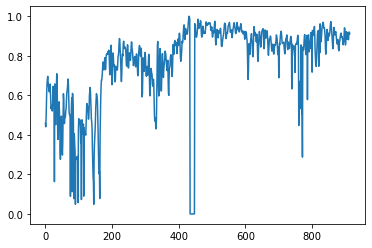

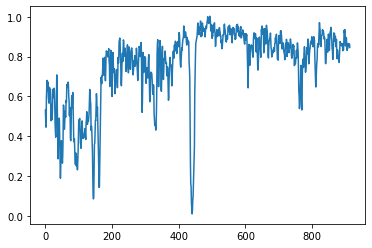

In [33]:
plt.figure()
plt.plot(train_cut[4])
plt.savefig("OG.png")
plt.figure()
plt.plot(decoded_imgs[4])
plt.savefig("RECON.png")
print(hist.history["val_loss"][-1])